# Prework

In [25]:
import sys
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import *
import tensorflow_probability as tfp
from tensorflow.keras.models import Model
import statsmodels.api as sm
from math import sqrt as math_sqrt
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import pickle
import math
import random

#Import custom modules
sys.path.append('../')
from utils.utils import *

In [26]:
print("TensorFlow version: {}".format(tf.__version__))
print("Eager execution: {}".format(tf.executing_eagerly()))

TensorFlow version: 2.4.1
Eager execution: True


## Load data

In [27]:
training_data, testing_data, testing_index = load_data()

In [28]:
countries, no_features, _ , years, months, weekdays, hours = load_data_information()

In [29]:
country_dict, feature_dict = get_dictionaries()
feature_names = list(feature_dict.keys())
country_names = list(country_dict.keys())
country_dict_reversed = {value : key for (key, value) in country_dict.items()}
feature_dict_reversed = {value : key for (key, value) in feature_dict.items()}

In [30]:
with open("../data/data_normalization.pkl", "rb") as p:
    mean, sd = pickle.load(p)

In [31]:
# Extracts features, year, etc. from whole data
def change_format(input_data):
    #Extract year from data matrix
    year_w = input_data[:,:,0:1]
    #Extract weekday from data matrix
    weekday_w = input_data[:,:,1:2]
    #Extract hour from data matrix
    hour_w = input_data[:,:,2:3]
    #Extract country from data matrix
    country_w = input_data[:,0:1,3]   
    #Extract month from data matrix
    month_w = input_data[:,:,4:5]
    #Extract features from matrix
    features_w = input_data[:,:,5:5+no_features]
    #Extract matrix of missing values from data matrix
    miss_vals_w = input_data[:,:,-no_features-6:-6]
    #Extract pos enc from data matrix
    pos_enc_w = input_data[:,:,-6:]


    #Prepare format for features
    features_tf = np.reshape(features_w, [features_w.shape[0], -1, 1])
    miss_vals_tf = np.reshape(miss_vals_w, [features_w.shape[0], -1, 1])
    pos_enc_tf = np.reshape(tf.transpose(np.repeat(np.reshape(pos_enc_w, [pos_enc_w.shape[0], pos_enc_w.shape[1], pos_enc_w.shape[2], 1]),
                                                   no_features, axis = 3), perm=[0,1,3,2]),[pos_enc_w.shape[0],-1,pos_enc_w.shape[2]])
    feature_nr_tf = np.repeat(np.reshape(np.repeat(np.reshape(np.array(range(no_features)),[1,-1]), input_data.shape[1], axis = 0),[1,-1]), input_data.shape[0], axis = 0)
    
    #Reshape other features
    hour_tf = np.reshape(np.repeat(hour_w, no_features,axis=2),[input_data.shape[0],-1])
    year_tf = np.reshape(np.repeat(year_w, no_features,axis=2),[input_data.shape[0],-1])
    weekday_tf = np.reshape(np.repeat(weekday_w, no_features,axis=2),[input_data.shape[0],-1])
    month_tf = np.reshape(np.repeat(month_w, no_features,axis=2),[input_data.shape[0],-1])
    
    

    return features_tf, miss_vals_tf, pos_enc_tf, country_w, year_tf, weekday_tf, hour_tf, feature_nr_tf

In [32]:
#Function for testing mask
def get_testing_mask(features, miss_vals, mask):
    mask = mask.reshape(features.shape)
    features_masked = np.array(features)
    features_masked[mask==1] = 0

    miss_vals_masked = np.array(miss_vals)
    miss_vals_masked[mask==1] = 1

    
    return features_masked, miss_vals_masked, mask

# Load predictions over several masks

In [33]:
metrics = ["MSE", "MAE","MAPE"]
models = ["transformer","lstm", "locf", "knn"]

In [34]:
multi_index = [np.round(np.arange(0.1,1,0.1),1),metrics]
results = pd.DataFrame(columns=models, index = pd.MultiIndex.from_product(multi_index, names=["Percentage", "Metric"]))
perc = np.round(np.arange(0.1,1,0.1),1)

for p in perc:
    #Load testing mask
    testing_mask = np.load("../evaluation/masks/testing_mask_{}.npy".format(p))

    #Obtain true values
    features, miss_vals, pos_enc, country, year, weekday, hour, feature_nr = change_format(testing_data)
    features_masked, miss_vals_masked, mask = get_testing_mask(features, miss_vals, testing_mask)
    true_values = features[mask==1]

    #Load model predictions
    for model in models:
        prediction = np.load("../data/predictions/{}_pred_{}.npy".format(model,p))

        #Calculate mse
        mse = np.round(mean_squared_error(true_values,prediction),6)
        mae = np.round(mean_absolute_error(true_values,prediction),6)
        mape = np.round(mean_absolute_percentage_error(true_values, prediction),6)

        #Save mse to results
        results.loc[(p,"MSE"),model]=mse
        results.loc[(p,"MAE"),model]=mae
        results.loc[(p,"MAPE"), model] = mape

In [35]:
results

transformer      lstm      locf       knn
Percentage Metric                                          
0.1        MSE       0.015422  0.015821  0.151234  0.077561
           MAE       0.043171  0.054634  0.111528  0.097025
           MAPE      0.770476  1.842533  1.855016  1.412781
0.2        MSE       0.016661  0.018583  0.159117  0.079219
           MAE       0.043357  0.055736  0.113199  0.097305
           MAPE      0.584529  0.767768  1.222407   1.45303
0.3        MSE       0.016856  0.019953  0.153013   0.07912
           MAE       0.044247  0.057757  0.111652  0.098128
           MAPE      0.582924  0.865146  1.312587  1.198359
0.4        MSE       0.018851   0.02222  0.152438  0.082234
           MAE       0.045571  0.059888  0.111468  0.099089
           MAPE      0.743198  1.439043  1.648245  1.708142
0.5        MSE       0.020926  0.025763  0.157073  0.087163
           MAE        0.04754  0.063357  0.112428  0.101389
           MAPE      0.865474  1.158654  1.731576  1.639834
0.6        MSE       0.023509  0.029796  0.155935   0.09061
           MAE       0.050028  0.067165  0.112115  0.102931
           MAPE      0.748464  1.268786  1.505607  1.558382
0.7        MSE       0.027033  0.033881  0.155623   0.09351
           MAE       0.053386  0.071908  0.112403  0.104959
           MAPE      0.793253  1.224979  1.534058   1.48171
0.8        MSE        0.03423  0.043553  0.156209  0.099675
           MAE       0.059293  0.079656  0.112523  0.107582
           MAPE      0.801338  1.267116  1.494341  1.529111
0.9        MSE       0.045838  0.056917  0.156211   0.10488
           MAE       0.068593  0.090373  0.112365  0.110312
           MAPE      1.049246  1.370682   1.57873  1.688202

Text(0.5, 1.0, 'MAPE')

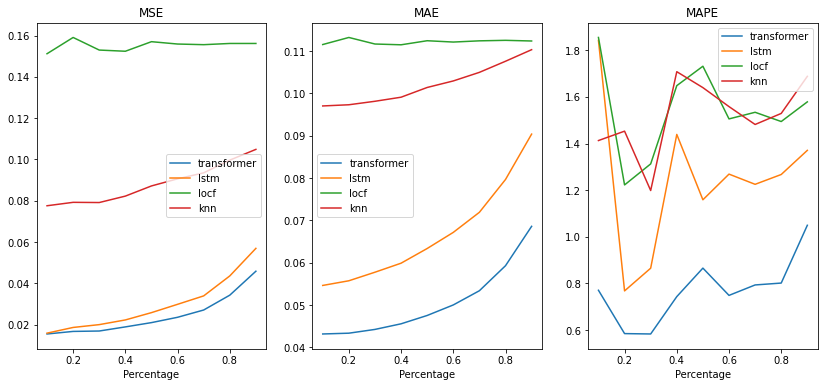

In [36]:
fig, axs = plt.subplots(1,3,figsize=(14,6))
results.loc[(slice(None),"MSE"),:].reset_index().drop("Metric",axis=1).set_index("Percentage").plot(ax = axs[0])
axs[0].set_title("MSE")
results.loc[(slice(None),"MAE"),:].reset_index().drop("Metric",axis=1).set_index("Percentage").plot(ax = axs[1])
axs[1].set_title("MAE")
results.loc[(slice(None),"MAPE"),:].reset_index().drop("Metric",axis=1).set_index("Percentage").plot(ax = axs[2])
axs[2].set_title("MAPE")

# Create evaluation scheme
Obtain a matrix with true values and information about each prediction in order to make full evaluation

In [37]:
def get_information_matrix(p, testing_data = testing_data, length = 120):
    testing_mask = np.load("../evaluation/masks/testing_mask_{}.npy".format(p))
    #Zieht die Informationen aus dem Testdatensatz
    features, miss_vals, pos_enc, country, year, weekday, hour, feature_nr = change_format(testing_data)
    features_masked, miss_vals_masked, mask = get_testing_mask(features, miss_vals, testing_mask)
    length = 120

    #Informationen über true values
    true_values_inf = features[mask==1]

    #Informationen über die Reihenfolge der Features
    feature_number_inf = feature_nr.reshape(feature_nr.shape[0],feature_nr.shape[1],1)[mask==1]

    #Informationen über die Länder
    country_inf = np.repeat(country,no_features*length,axis=1).reshape(country.shape[0],no_features*length,1)[mask==1]

    #Informationen über die Zeitreihe
    time_index_reshaped = np.repeat(testing_index.reshape(testing_index.shape[0],testing_index.shape[1],1),no_features,axis=2)
    time_index_inf = time_index_reshaped.reshape(testing_index.shape[0],no_features*length,1)[mask==1]

    #Informationen über die Sample (Tages-) nummer
    sample_inf = np.repeat(np.arange(testing_data.shape[0]).reshape(testing_data.shape[0],1),no_features*length,axis=1).reshape(testing_data.shape[0],no_features*length,1)[mask==1]
    
    # Informationen in einem Dataframe sammeln
    information_concat = np.concatenate((time_index_inf, sample_inf, country_inf,feature_number_inf, true_values_inf),axis=0).reshape(-1,true_values_inf.shape[0])
    results = pd.DataFrame(information_concat[1:].transpose(), index = information_concat[0], columns = [
        "Sample","Country", "Feature", "True value"])
    results["Country"]=results["Country"].astype("int")
    results["True value"] = pd.to_numeric(results["True value"])
    
    return results

In [38]:
def get_results_matrix(p, methods, renormalize=True, adjust = True):
    information = get_information_matrix(p)
    
    #Load predictions
    for method in methods:
        information["{}_pred".format(method)] = np.load("../data/predictions/{}_pred_{}.npy".format(method, p))
        
    information["Feature"] = information["Feature"].map(feature_dict_reversed)
    information["Country"] = information["Country"].map(country_dict_reversed)
    
    #If renormalization is activated
    if renormalize == True:
        features_list = information["Feature"].unique().tolist()
        columns = list(information.columns[3:])
        for feature in features_list:
            information.loc[information["Feature"] == feature,columns] = (information.loc[information["Feature"] == feature,columns] * sd[feature]) + mean[feature]
        information.loc[:,columns] = information.loc[:,columns].astype("float64")
        information = information.round(4)
        
        #Check for adjusting subzero values
        if adjust == True:
            neg_columns = information.iloc[:,3:].copy()
            neg_columns[neg_columns < 0] = 0
            information.iloc[:,3:] = neg_columns
    
    else:    
        #Remove values lower than zero
        if adjust == True:
            adjust_column = -mean/sd
            adjust_column = adjust_column[5:]
            feature_list = list(adjust_column.index)
            for method in information.columns[4:6]:
                for x, feature in enumerate(feature_list):
                    value = adjust_column[x]
                    information.loc[(information["Feature"] == feature) & (information[method] < value),method] = value
        
    return information

In [39]:
def get_metrics(p, models = models, adjust = False):
    results = get_results_matrix(p, models, renormalize = False, adjust = adjust)
    metrics_res = pd.DataFrame(columns = models)

    for model in models:
        mse = mean_squared_error(results["True value"], results["{}_pred".format(model)])
        mae = mean_absolute_error(results["True value"], results["{}_pred".format(model)])
        metrics_res.loc[:,model] = [mse,mae]

    metrics_res.index = metrics
    return metrics_res

In [16]:
results = get_results_matrix(0.5, models, renormalize = True)

In [17]:
get_metrics(0.5)

,transformer,lstm,locf,knn
MSE,0.020926,0.025763,0.157073,0.087163
MAE,0.047540,0.063357,0.112428,0.101389


# Development: Model evaluation

## Evaluate Models per Feature

In [155]:
def get_metrics_per_feature(feature):

    multi_index = [np.round(np.arange(0.1,1,0.1),1),metrics]
    metrics_per_feature = pd.DataFrame(columns=methods, index = pd.MultiIndex.from_product(multi_index, names=["Percentage", "Metric"]))

    for p in perc:

        results = get_results_matrix(p, models, False, True)
        results = results.loc[results["Feature"] == feature]
        true_values = results["True value"]
        for method in methods:
            prediction = results[method]
            mse = np.round(mean_squared_error(true_values,prediction),6)
            mae = np.round(mean_absolute_error(true_values,prediction),6)
            mape = np.round(mean_absolute_percentage_error(true_values, prediction),6)

            #Add to dataframe
            metrics_per_feature.loc[(p,"MSE"),method] = mse
            metrics_per_feature.loc[(p,"MAE"),method] = mae
            metrics_per_feature.loc[(p,"MAPE"), method] = mape

    fig, axs = plt.subplots(1,3,figsize=(14,6))
    metrics_per_feature.loc[(slice(None),"MSE"),:].reset_index().drop("Metric",axis=1).set_index("Percentage").plot(ax = axs[0])
    axs[0].set_title("MSE - Feature: {}".format(feature))
    metrics_per_feature.loc[(slice(None),"MAE"),:].reset_index().drop("Metric",axis=1).set_index("Percentage").plot(ax = axs[1])
    axs[1].set_title("MAE - Feature: {}".format(feature))
    metrics_per_feature.loc[(slice(None),"MAPE"),:].reset_index().drop("Metric",axis=1).set_index("Percentage").plot(ax = axs[2])
    axs[2].set_title("MAPE - Feature: {}".format(feature))

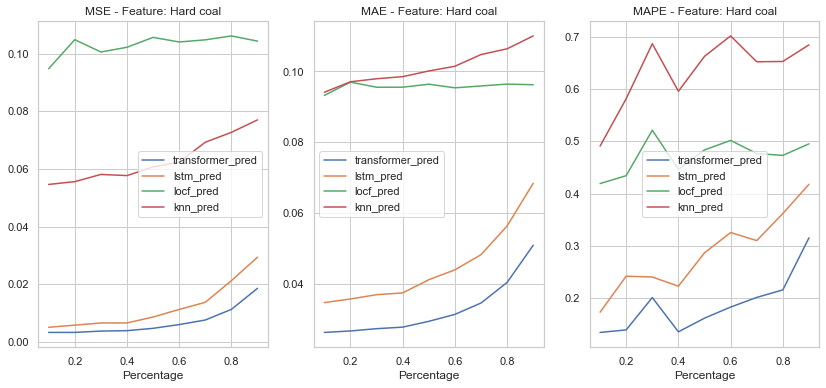

In [156]:
get_metrics_per_feature("Hard coal")

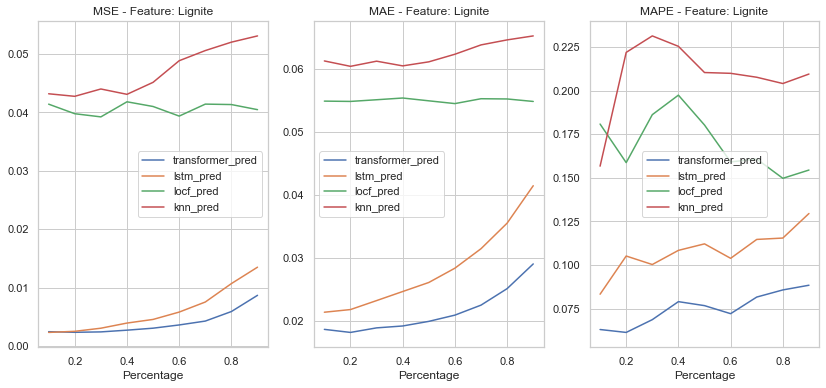

In [136]:
get_metrics_per_feature("Lignite")

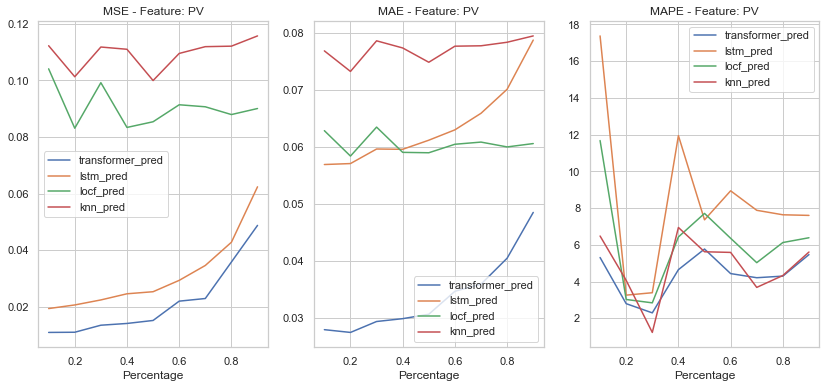

In [137]:
get_metrics_per_feature("PV")

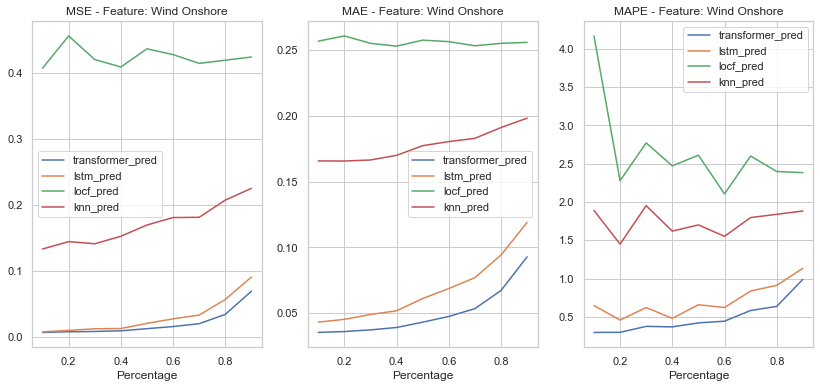

In [138]:
get_metrics_per_feature("Wind Onshore")

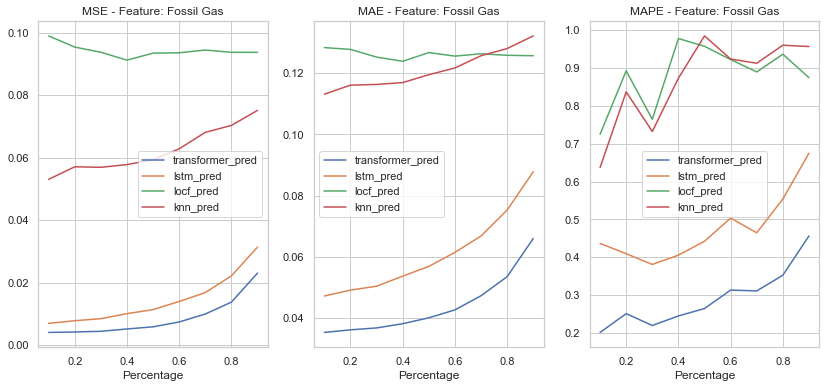

In [139]:
get_metrics_per_feature("Fossil Gas")

# Plot results

## Plot random sample

In [142]:
results = get_results_matrix(0.7, models, renormalize = False)

In [143]:
import matplotlib.dates as mdates

def get_sample_plot(data=results):
    sample = np.random.choice(data["Sample"].unique())
    data_plot = data[data["Sample"]==sample]
    features = data_plot["Feature"].unique()

    fig, axs = plt.subplots(1,5,figsize=(30,8))
    axs = axs.ravel()
    z=-1
    features = np.random.choice(feature_names,5)
    for feature in features:
        z+=1
        data = data_plot[data_plot["Feature"]==feature]
        axs[z].plot(data.iloc[:,3:],'--o')
        axs[z].legend(data.iloc[:,3:].columns)
        axs[z].set_title("Country : {}, Feature: {}".format(data_plot["Country"][0],feature))
        axs[z].xaxis.set_major_formatter(mdates.DateFormatter("%H"))

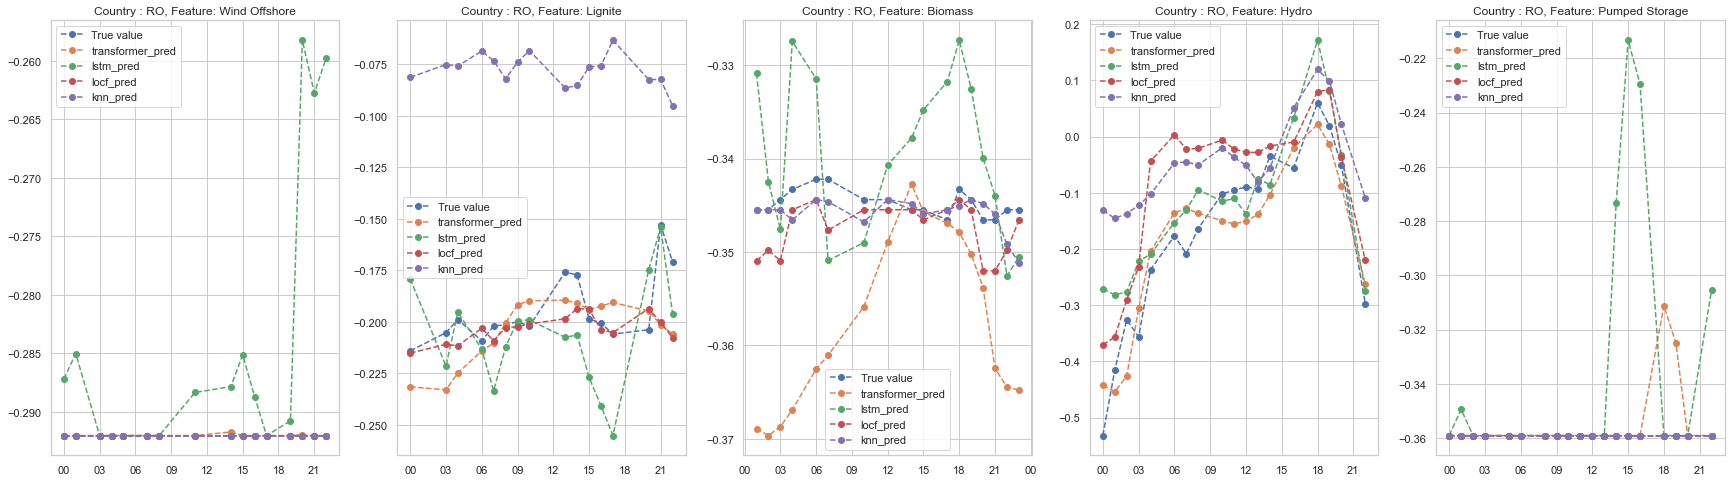

In [144]:
get_sample_plot()

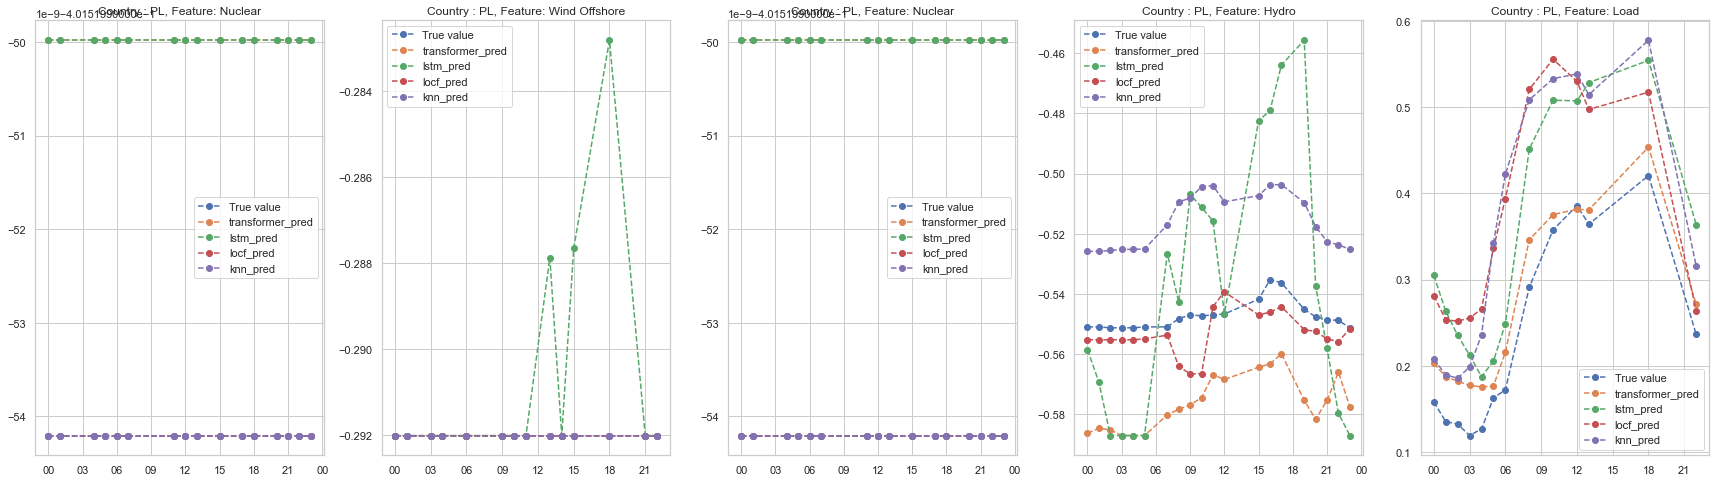

In [145]:
get_sample_plot()

## Plot samples per feature

In [146]:
feature_dict

{'Day_ahead_price': 0,
 'Load': 1,
 'Biomass': 2,
 'Fossil Gas': 3,
 'Hard coal': 4,
 'Pumped Storage': 5,
 'Other': 6,
 'PV': 7,
 'Wind Onshore': 8,
 'Lignite': 9,
 'Nuclear': 10,
 'Wind Offshore': 11,
 'Hydro': 12}

In [147]:
def plot_samples_per_feature(feature, results = results, feature_dict_reversed = feature_dict_reversed):
    feature_name = feature_dict_reversed[feature]
    data_plot=results[results["Feature"]==feature_name]
    samples = np.random.choice(data_plot["Sample"].unique(),5)

    fig, axs = plt.subplots(1,5,figsize=(25,5))
    z=-1
    for sample in samples:
        z+=1
        data = data_plot[data_plot["Sample"]==sample]
        axs[z].plot(data.iloc[:,3:],'--o')
        axs[z].legend(data.iloc[:,3:].columns)
        axs[z].set_title("Country : {}, Feature: {}".format(data["Country"][0],feature_name))
        axs[z].xaxis.set_major_formatter(mdates.DateFormatter("%H"))

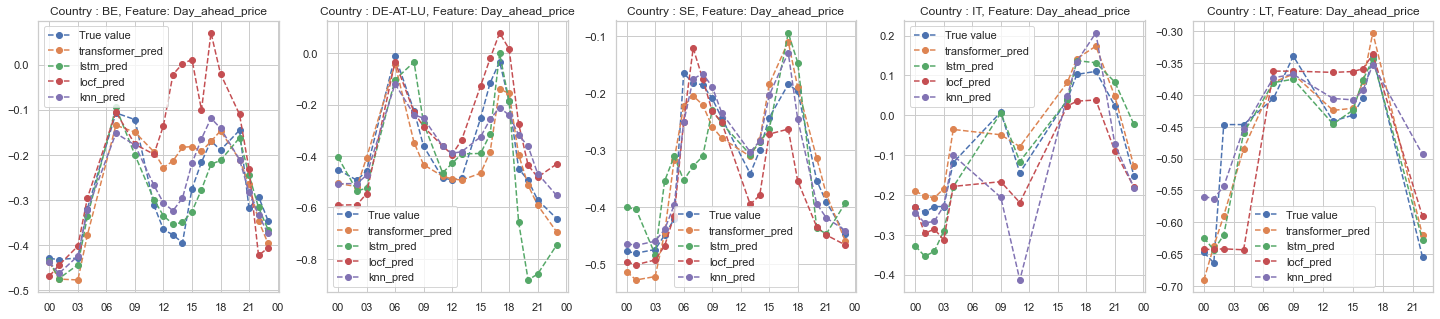

In [148]:
plot_samples_per_feature(0)

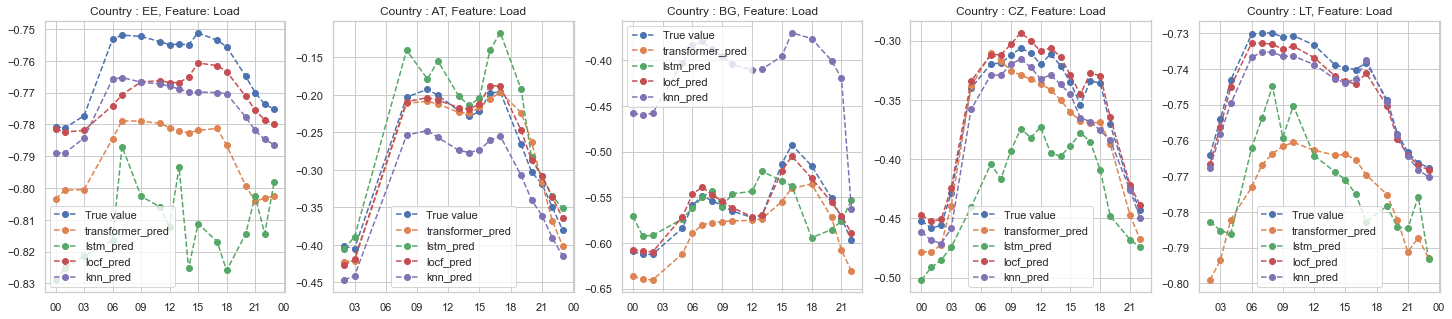

In [149]:
plot_samples_per_feature(1)

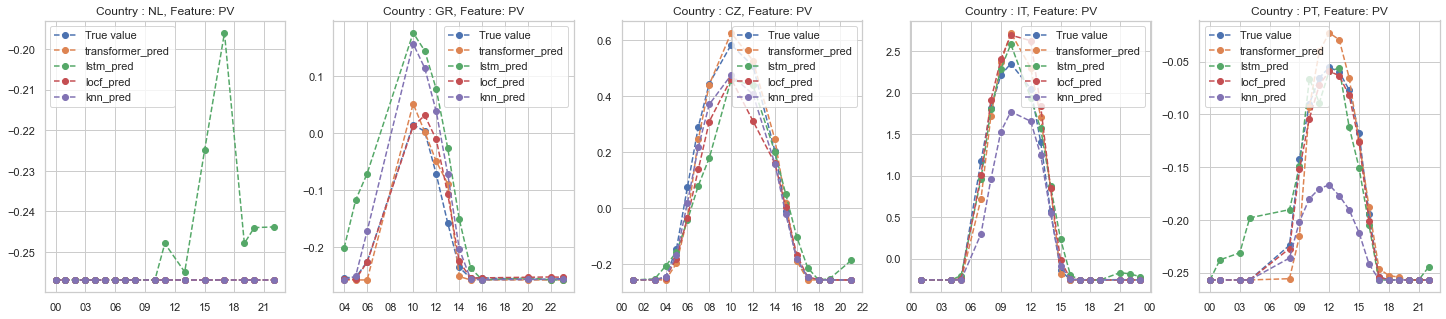

In [150]:
plot_samples_per_feature(7)

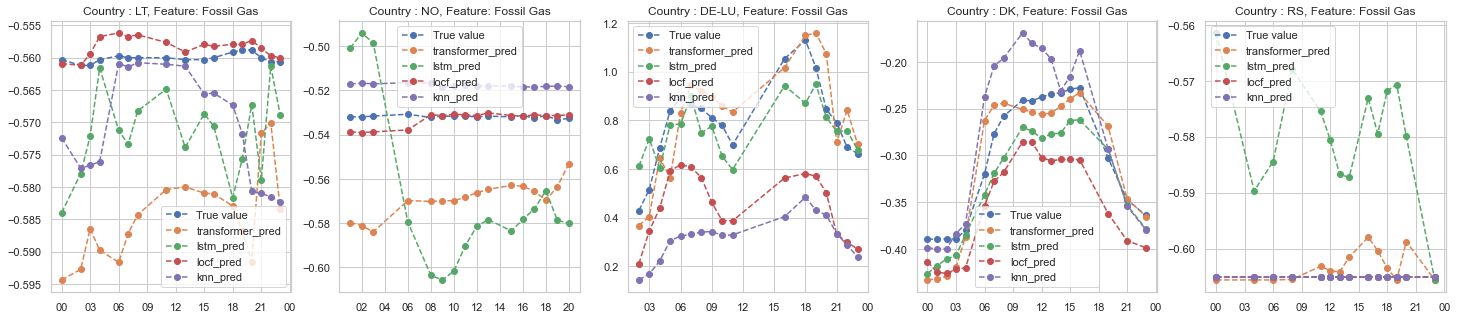

In [151]:
plot_samples_per_feature(3)

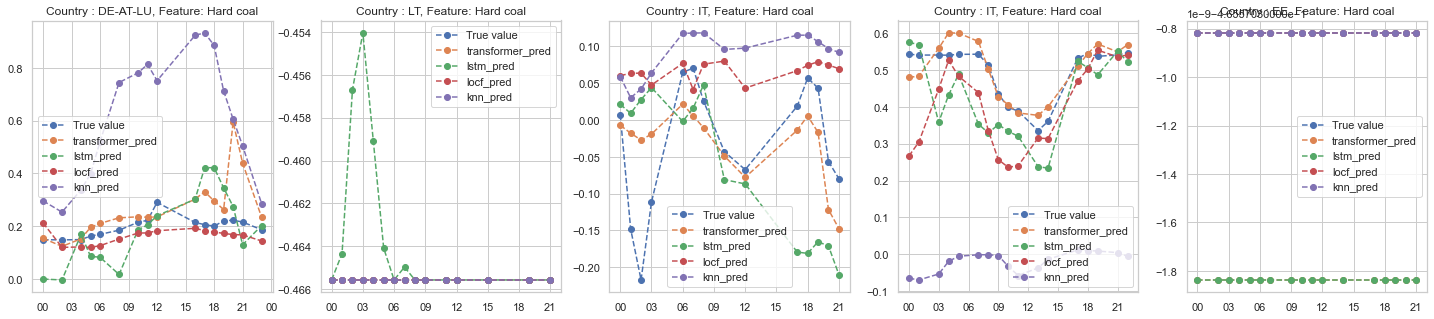

In [152]:
plot_samples_per_feature(4)

# Green house gas emissions

## Keys

Emissions in kg CO2 eq /MWh (2015)

Metal Depletion in kg FE eq/MWh (2015)

In [21]:
ghg_emissions = {
    "Nuclear" : 11.7,
    "Hard coal" : 1227.3,
    "Lignite" : 1229.0,
    "Fossil Gas" : 488.4,
    "Hydro" : 4.6,
    "Pumped Storage" : 56.8,
    "Biomass" : 201.4,
    "PV" : 85.8,
    "Wind Offshore" : 27.1,
    "Wind Onshore" : 27.1
}

metal_depletion = {
    "Nuclear" : 4.1,
    "Hard coal" : 2.0,
    "Lignite" : 2.3,
    "Fossil Gas" : 3.2,
    "Hydro" : 1.7,
    "Pumped Storage" : 4.7,
    "Biomass" : 5.2,
    "PV" : 24.6,
    "Wind Offshore" : 23.5,
    "Wind Onshore" : 23.5
}

In [22]:
results_summed = results.groupby(["Feature"]).sum()
results_summed

KeyError: 'Feature'

In [36]:
emissions = results_summed.loc[(list(ghg_emissions.keys(),)),:].reset_index()

In [41]:
def get_emissions(x):
    return x[1:] * ghg_emissions[x["Feature"]]

def get_depletion(x):
    return x[1:] * metal_depletion[x["Feature"]]

In [38]:
emissions.iloc[:,1:] = emissions.apply(lambda x: get_emissions(x), axis = 1)

complete_emissions = emissions.sum()

In [39]:
complete_emissions[1:]
normalized_emissions = complete_emissions[1:]/complete_emissions[1]

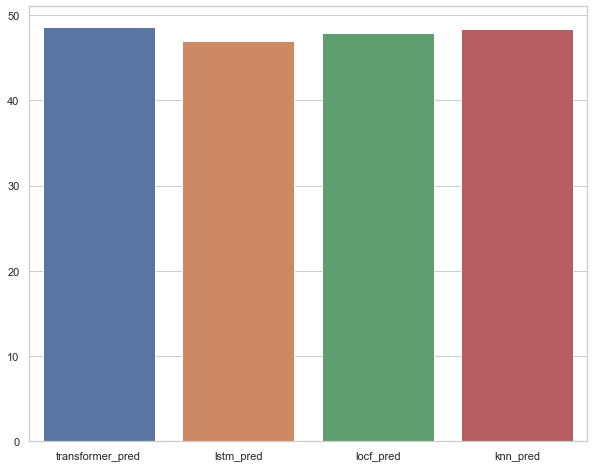

In [48]:
sns.set_theme(style="whitegrid")
fig, ax = plt.subplots(figsize= (10,8))
ax = sns.barplot(y = complete_emissions[1:], x = complete_emissions[1:].index.tolist())

Metal depletion

In [41]:
depletion = results_summed.loc[(list(metal_depletion.keys(),)),:].reset_index()

In [42]:
depletion.iloc[:,1:] = depletion.apply(lambda x: get_depletion(x), axis = 1)

complete_depletion = depletion.sum()

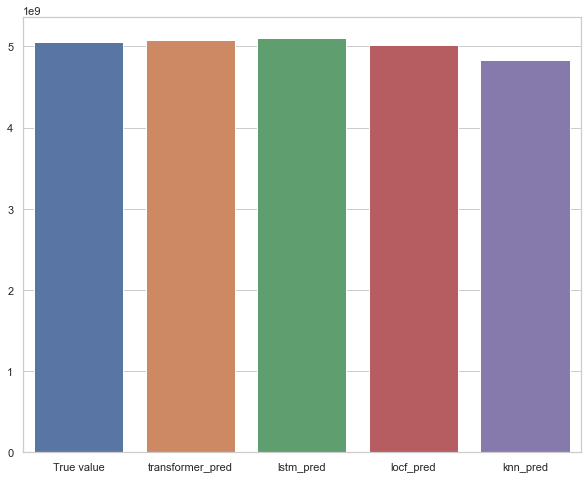

In [43]:
fig, ax = plt.subplots(figsize= (10,8))
ax = sns.barplot(y = complete_depletion[1:], x = complete_depletion[1:].index.tolist())

## Get complete emissions and depletion table

In [46]:
# Prepare dataframe
multi_index = [np.round(np.arange(0.1,1,0.1),1),["Emissions","Metal depletion"]]
results_diff = pd.DataFrame(columns = methods, index = pd.MultiIndex.from_product(multi_index, names=["Percentage", "Metric"]))
results_diff["True value"] = 0
methods = results.columns[4:].to_list()

for p in perc:
    #Get results
    results = get_results_matrix(p, models, True, True)
    #Calculate emissions and depletion
    results_summed = results.groupby(["Feature"]).sum()
    emissions = results_summed.loc[(list(ghg_emissions.keys(),)),:].reset_index()
    depletion = results_summed.loc[(list(metal_depletion.keys(),)),:].reset_index()
    
    #Emissions
    emissions.iloc[:,1:] = emissions.apply(lambda x: get_emissions(x), axis = 1)
    complete_emissions = emissions.iloc[:,1:].sum()
    #Convert to Mt
    complete_emissions = complete_emissions / 10e9

    #Depletion
    depletion.iloc[:,1:] = depletion.apply(lambda x: get_depletion(x), axis = 1)
    complete_depletion = depletion.iloc[:,1:].sum()
    # Convert to Mt
    complete_depletion = complete_depletion / 10e9
    
    for method in methods:
        emission_true = complete_emissions["True value"]
        depletion_true = complete_depletion["True value"]

        results_diff.loc[(p, "Emissions"),method] = (complete_emissions[method] - emission_true)/emission_true * 100
        results_diff.loc[(p, "Emissions"),"True value"] = emission_true
        results_diff.loc[(p, "Metal depletion"),method] = (complete_depletion[method] - depletion_true)/depletion_true * 100
        results_diff.loc[(p, "Metal depletion"),"True value"] = depletion_true      

### Plot complete emissions

Text(0, 0.5, 'Abweichung vom Originalwert [%]')

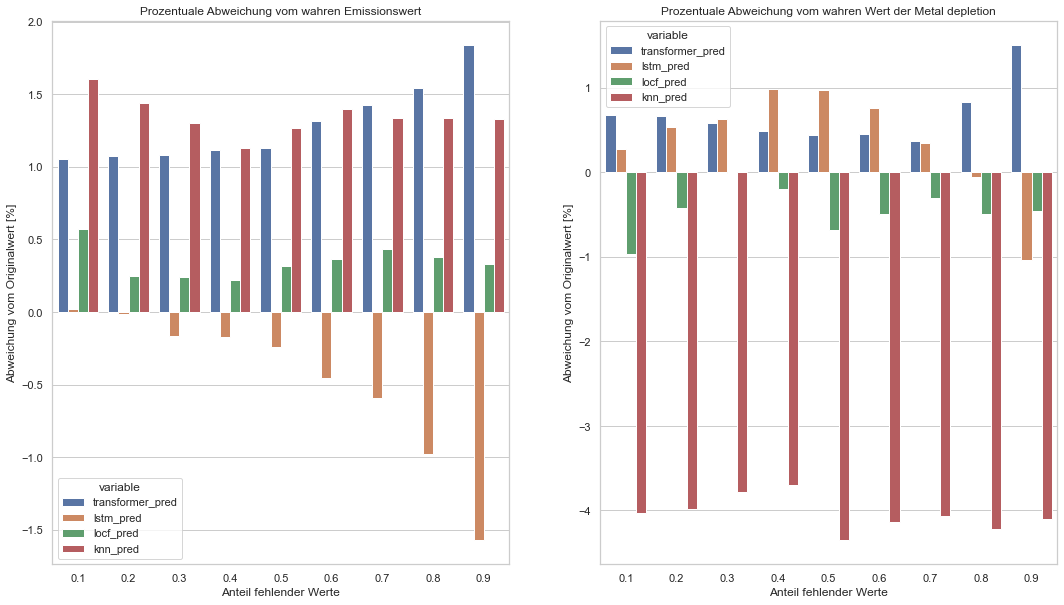

In [49]:
fig, ax = plt.subplots(1,2,figsize= (18,10))

emissions_plot = results_diff.loc[(slice(None),"Emissions"),].reset_index().drop(["Metric","True value"], axis = 1).melt("Percentage")
depletion_plot = results_diff.loc[(slice(None),"Metal depletion"),].reset_index().drop(["Metric", "True value"], axis = 1).melt("Percentage")

#Plot emissions
sns.barplot(x = "Percentage", y = "value", hue = "variable", data = emissions_plot, ax = ax[0])
ax[0].set_title("Prozentuale Abweichung vom wahren Emissionswert")
ax[0].set_xlabel("Anteil fehlender Werte")
ax[0].set_ylabel("Abweichung vom Originalwert [%]")
#Plot depletion
sns.barplot(x = "Percentage", y = "value", hue = "variable", data = depletion_plot, ax = ax[1])
ax[1].set_title("Prozentuale Abweichung vom wahren Wert der Metal depletion")
ax[1].set_xlabel("Anteil fehlender Werte")
ax[1].set_ylabel("Abweichung vom Originalwert [%]")

## Emissions on feature

In [106]:
methods = results.columns[4:].to_list()
def get_diff_by_feature(feature, methods = methods, ):
    # Prepare dataframe
    multi_index = [np.round(np.arange(0.1,1,0.1),1),["Emissions","Metal depletion"]]
    results_diff = pd.DataFrame(columns = methods, index = pd.MultiIndex.from_product(multi_index, names=["Percentage", "Metric"]))
    results_diff["True value"] = 0
   

    for p in perc:
        #Get results
        results = get_results_matrix(p, models, True, True)
        #Calculate emissions and depletion
        results_summed = results[results["Feature"] == feature].drop(["Sample", "Country", "Feature"], axis = 1).sum()

        #Emissions
        results_summed = results[results["Feature"] == feature].drop(["Sample", "Country", "Feature"], axis = 1).sum()
        emissions = results_summed.iloc[1:] * ghg_emissions[feature]
        #Convert to Mt
        emissions = emissions / 10e9

        #Depletion
        depletion = results_summed.iloc[1:] * metal_depletion[feature]
        # Convert to Mt
        depletion = depletion / 10e9
        
        emission_true = results_summed["True value"] * ghg_emissions[feature] / 10e9
        depletion_true = results_summed["True value"] * metal_depletion[feature] / 10e9

        for method in methods:
            results_diff.loc[(p, "Emissions"),method] = (emissions[method] - emission_true)/emission_true * 100
            results_diff.loc[(p, "Emissions"),"True value"] = emission_true
            results_diff.loc[(p, "Metal depletion"),method] = (depletion[method] - depletion_true)/depletion_true * 100
            results_diff.loc[(p, "Metal depletion"),"True value"] = depletion_true  

    fig, ax = plt.subplots(1,2,figsize= (12,8))

    emissions_plot = results_diff.loc[(slice(None),"Emissions"),].reset_index().drop(["Metric","True value"], axis = 1).melt("Percentage")
    depletion_plot = results_diff.loc[(slice(None),"Metal depletion"),].reset_index().drop(["Metric", "True value"], axis = 1).melt("Percentage")

    #Plot emissions
    sns.barplot(x = "Percentage", y = "value", hue = "variable", data = emissions_plot, ax = ax[0])
    ax[0].set_title("Prozentuale Abweichung vom wahren Emissionswert - Feature: {}".format(feature))
    ax[0].set_xlabel("Anteil fehlender Werte")
    ax[0].set_ylabel("Abweichung vom Originalwert [%]")
    #Plot depletion
    sns.barplot(x = "Percentage", y = "value", hue = "variable", data = depletion_plot, ax = ax[1])
    ax[1].set_title("Prozentuale Abweichung vom wahren Wert der Metal depletion- Feature: {}".format(feature))
    ax[1].set_xlabel("Anteil fehlender Werte")
    ax[1].set_ylabel("Abweichung vom Originalwert [%]")

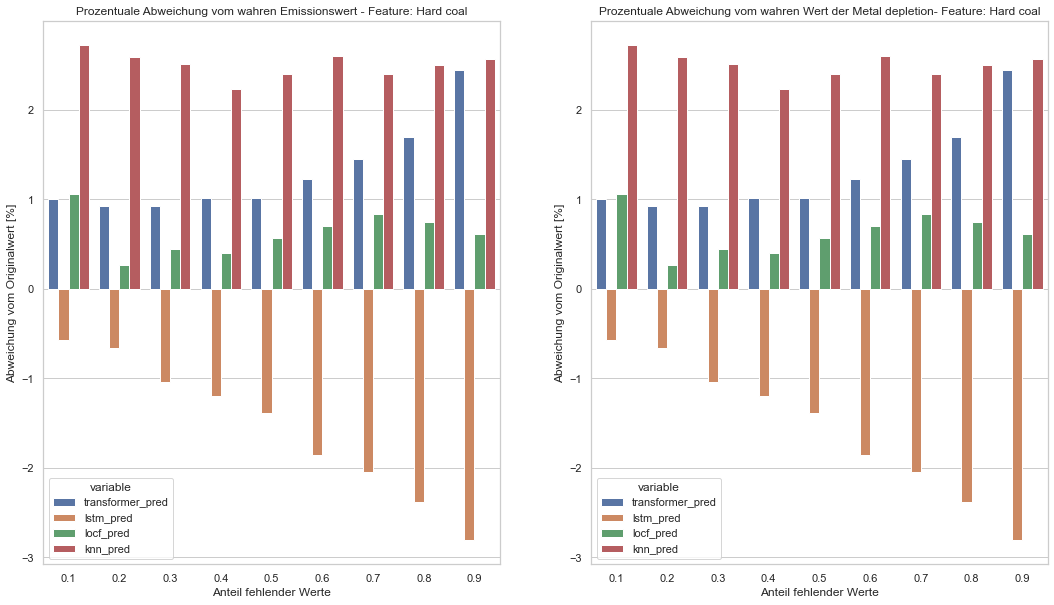

In [100]:
get_diff_by_feature("Hard coal")

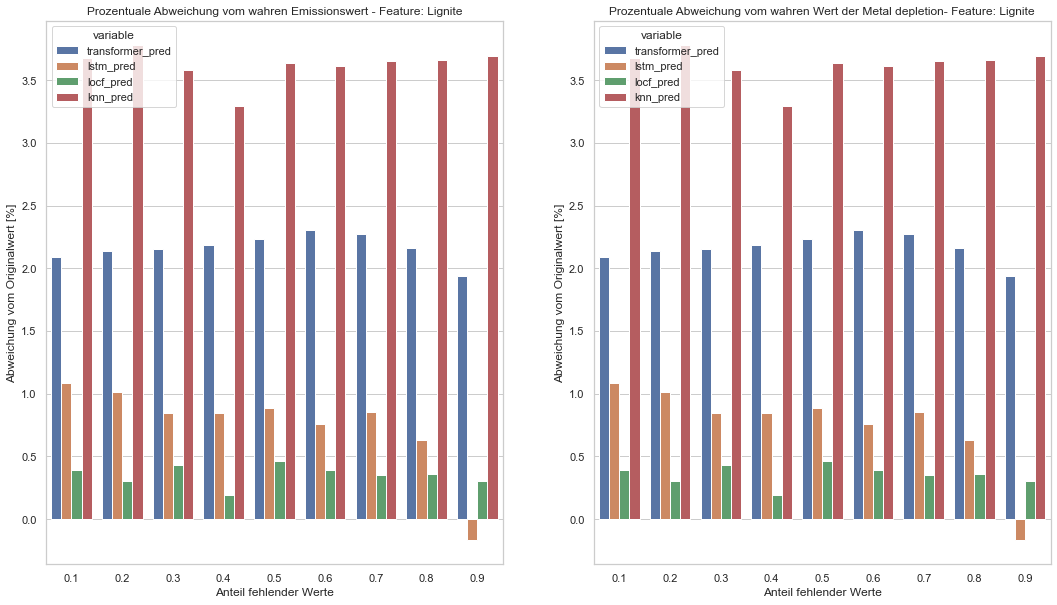

In [101]:
get_diff_by_feature("Lignite")

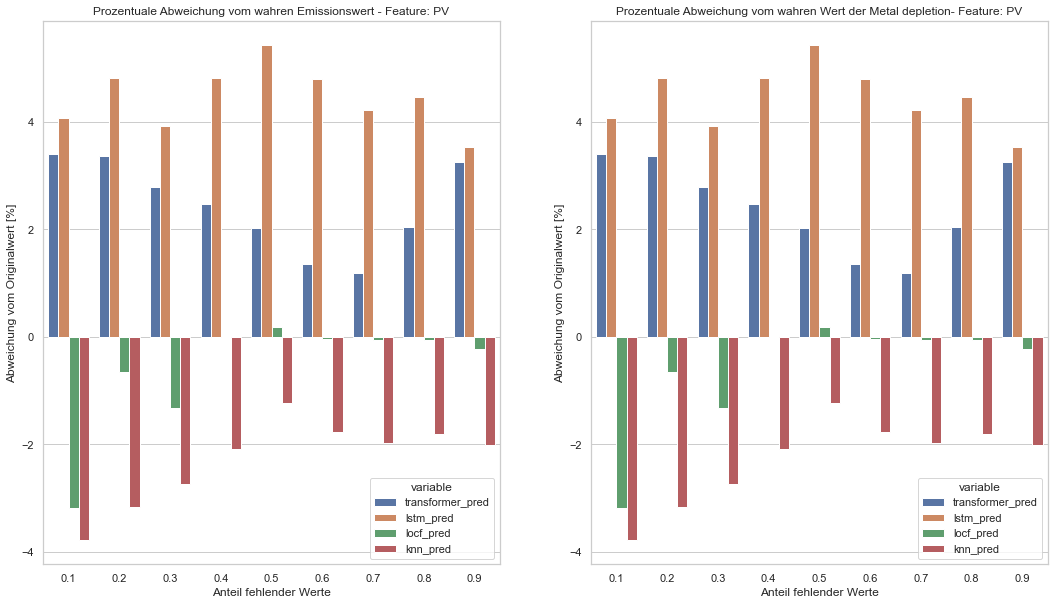

In [102]:
get_diff_by_feature("PV")

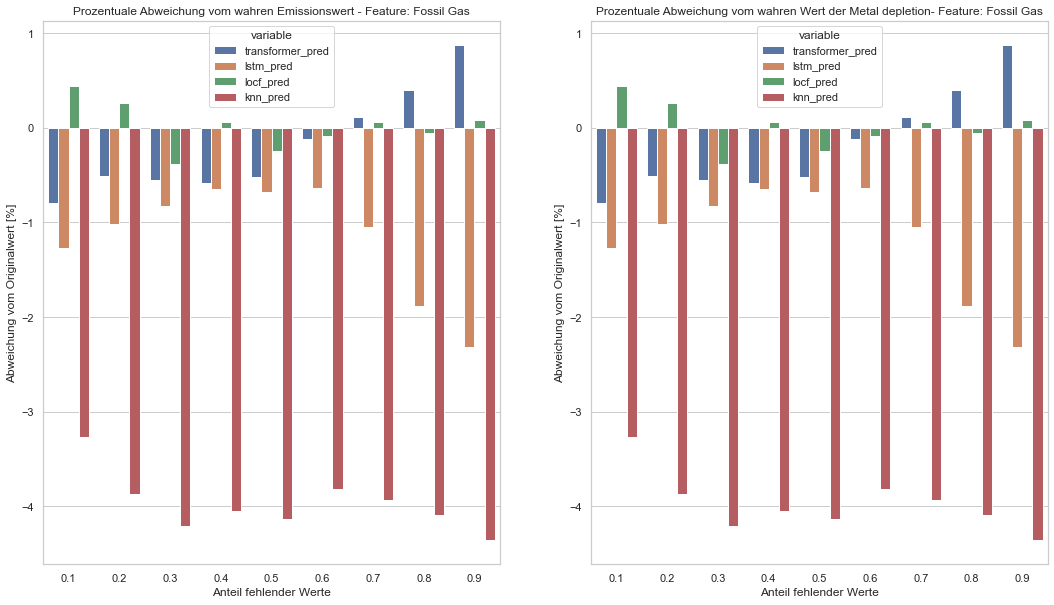

In [104]:
get_diff_by_feature("Fossil Gas")

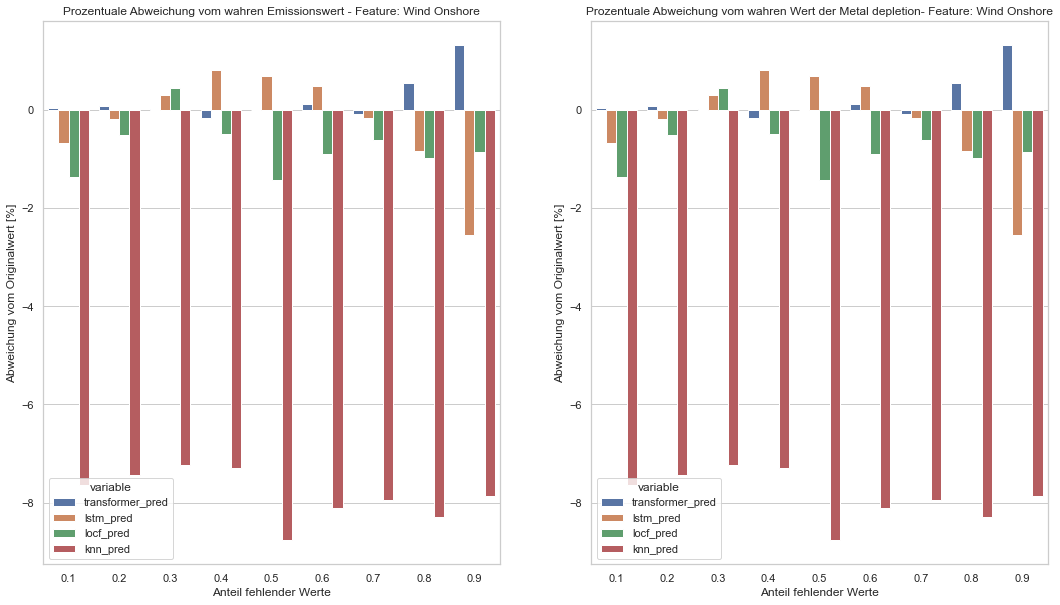

In [103]:
get_diff_by_feature("Wind Onshore")

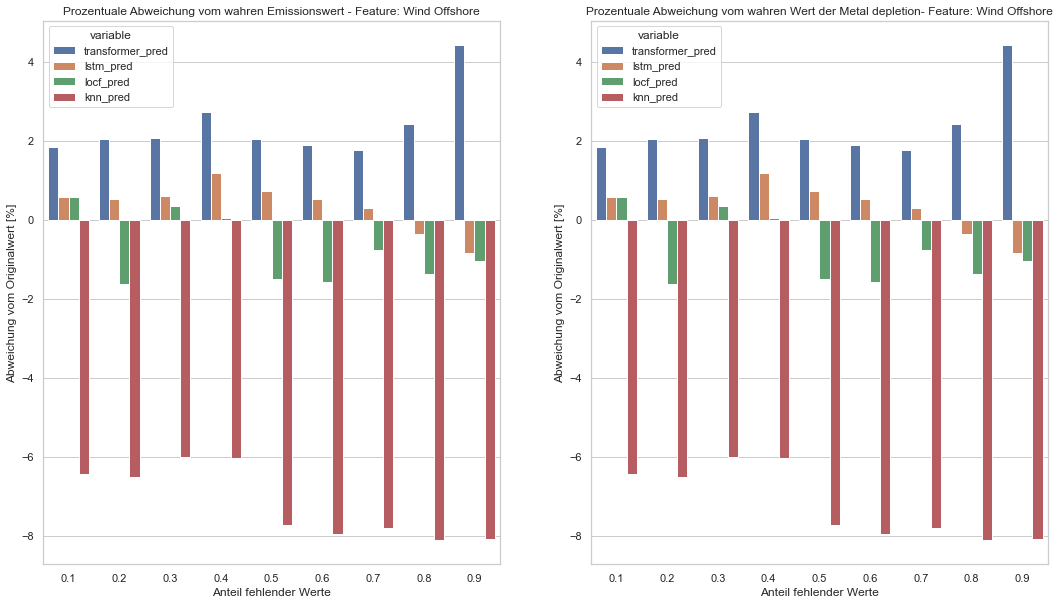

In [105]:
get_diff_by_feature("Wind Offshore")

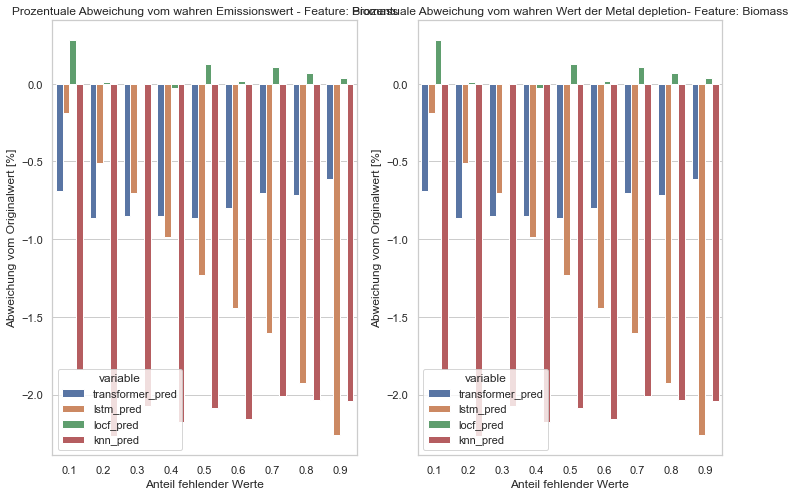

In [107]:
get_diff_by_feature("Biomass")